In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [26]:
include("src/utils.jl")
include("src/expo_environment.jl")
include("src/raycaster.jl")
include("src/nb_1.jl");

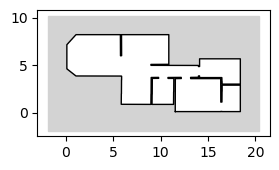

(187, 4)


In [27]:
env = load_env(2010)
println(size(env.segs))
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

# Utilities

In [28]:
"""
    is_valid_move(x, y, env::Env)

Checks if the step from `x` to `y` passes through an 
obstacle, and if so returns a scalar `s`  such that 
`(1-s)*x + s*y` encodes the intersection with the boundary
"""
function is_valid_move(x, y, env::Env)
    v = y - x
    _,C,S,T = ray_coll([x;y], env.segs) 
    if sum(C) == 0
        return true, nothing
    else
        s = min(S[C]...)
        return s > 1., s
    end
end;

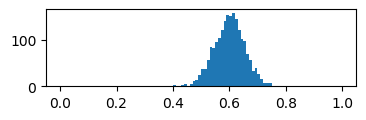

0.6005086307677207

In [29]:
"Beta-like distribution over a bigger interval."
@dist function my_scaled_beta(a, mean, scale)
    mean_beta = mean/scale
    b = a/mean_beta - a
    scale*beta(a,b);
end;

a = 50.
mean_speed = .6
max_speed = 1.

samples = [my_scaled_beta(a, mean_speed, max_speed) for t=1:2000]
plt.figure(figsize=(4,1));
plt.hist(samples, bins=0:max_speed/100:max_speed);
mean(samples)

# Controller- and Transition Model

In [30]:
"""
    Control

Contains the controls of the agent. 
"""
struct Control <: StructIterator
    "speed"
    s::Float64 
    "change of head direction"
    dhd::Float64
end;


"""
    control_prior(mean_speed, max_speed, dhd_noise)

Mindlessly samples a random control vector.
"""
@gen function control_prior(mean_speed, max_speed, dhd_noise)
    s   ~ my_scaled_beta(50., mean_speed, max_speed)
    dhd ~ normal(0, dhd_noise)
    return Control(s, dhd)
end;

In [31]:
"""
    motion_model(pose::Pose, u::Control, hd_noise, x_noise) 

A motion model for an agent that does **not** respect environmental boundaries.
"""
@gen function motion_model(pose::Pose, u::Control, hd_noise, x_noise)    
    hd ~ normal(pose.hd + u.dhd, hd_noise) 
    v = [u.s*cos(hd); u.s*sin(hd)]
    x ~ mvnormal(pose.x + v, Diagonal([x_noise, x_noise]))
    return Pose(x, hd)
end;

# Model w/o Mapping 

In [32]:
@gen (static) function localization_kernel(t::Int, 
                          pose::Pose, 
                          env::Env, 
                          control_args,
                          transition_args,
                          sensor_args)

    mean_speed, max_speed, dhd_noise = control_args
    hd_noise, x_noise                = transition_args
    fov, n, a_noise, z_noise, max_z  = sensor_args
    
    u     = @trace(control_prior(mean_speed, max_speed, dhd_noise), :u)
    pose  = @trace(motion_model(pose, u, hd_noise, x_noise), :pose)
    s     = @trace(sensor_model(pose, env, fov, n, a_noise, z_noise, max_z), :sense)
    
    return pose
end

loc_chain = Gen.Unfold(localization_kernel);
Gen.load_generated_functions();

In [33]:
function draw_tr!(tr, t=nothing; ax=plt.gca())
    T,_,env = get_args(tr)
    p = [tr[t => :pose] for t=1:T]
    x = hcat(map((q)->q.x, p)...)
    hd = map((q)->q.hd, p)
    s = [tr[t => :sense] for t=1:T]
    
    ax.set_aspect(1); ax.axis("off")
    draw_env!(env)
    ax.plot(x[1,:], x[2,:], marker=".", alpha=0.5)
    if t != nothing
        draw_pose!(p[t], ax=ax)
        draw_sense!(s[t], p[t], ax=ax, s= 10) 
    end
end

draw_tr! (generic function with 2 methods)

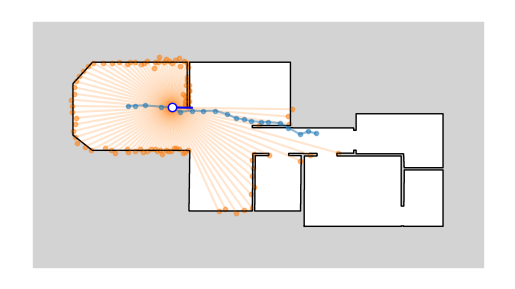

PyObject <matplotlib.collections.PathCollection object at 0x7f9166494e50>

In [34]:
# Config
# ---
T = 20
control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.01, x_noise=0.01)
sensor_args  = (fov=180, n=100, a_noise=1e-5, z_noise=1e-2, max_z=30.)


# Initial state of the chain
# ---
p0 = Pose([2.5; 6.], -0.1)

tr = Gen.simulate(loc_chain, (T,p0,env,control_args, motion_args, sensor_args));
ch = get_choices(tr);
draw_tr!(tr,5)

# Inference

In [35]:
data = load("example_sensor_data.jld")

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Dict{String,Any} with 10 entries:
  "n"       => 100
  "s"       => [1.0, 1.0, 0.949818, 1.0, 1.0, 1.0, 1.0, 1.0, 0.631622, 1.0, 1.0…
  "fov"     => 180
  "hd"      => [2.68723, 2.68723, 2.68723, 2.68723, 2.02111, 2.96523, 2.96523, …
  "env_id"  => 2010
  "x"       => Any[[15.474, 1.94666], [14.5754, 2.38555], [13.6769, 2.82444], […
  "z"       => Any[[0.949706, 0.925378, 0.905751, 0.89038, 0.878933, 0.871171, …
  "a"       => Any[[-3.11018, -3.04734, -2.98451, -2.92168, -2.85885, -2.79602,…
  "dhd"     => [0.0, 0.0, -8.88178e-16, -0.666124, 0.944122, -4.44089e-16, 4.44…
  "max_val" => Inf

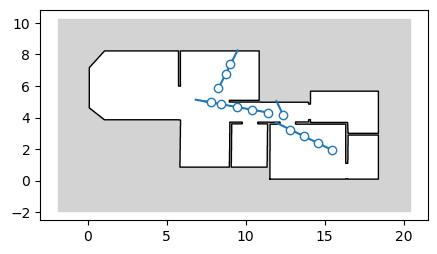

12


In [46]:
fov, n, max_val = data["fov"], data["n"], data["max_val"]

poses = []
senses = []
us = []

for (x, hd) in zip(data["x"], data["hd"])
    push!(poses, Pose(x, hd))
end


for (s,dhd) in zip(data["s"], data["dhd"])
    push!(us, Control(s,dhd))
end


for (z,a) in zip(data["z"], data["a"])
    push!(senses, Measurement(z, a))
end


T = length(us)

println(T)
# -------
plt.figure(figsize=(5,5)); plt.gca().set_aspect(1.);
plt.title("True poses of the agent")
draw_env!(env, zorder=-1);
for p in poses
    draw_pose!(p, c="C0")
end

In [37]:
function set_z!(ch, z, t)
    ch[t => :sense => :z] = z
end

function set_u!(ch, u, t)
    ch[t => :u => :s] = u.s
    ch[t => :u => :dhd] = u.dhd
end

function set_p!(ch, p, t)
    ch[t => :pose => :x]  = p.x
    ch[t => :pose => :hd] = p.hd;
end;

## MH Inference

t: 1...  0.321770 seconds (871.41 k allocations: 713.467 MiB, 39.89% gc time)
t: 2...  0.296834 seconds (823.71 k allocations: 710.983 MiB, 37.98% gc time)
t: 3...  0.328836 seconds (826.42 k allocations: 711.035 MiB, 43.17% gc time)
t: 4...  0.331043 seconds (829.60 k allocations: 711.093 MiB, 42.18% gc time)
t: 5...  0.336520 seconds (827.88 k allocations: 711.059 MiB, 45.95% gc time)
t: 6...  0.302640 seconds (826.13 k allocations: 711.029 MiB, 41.16% gc time)
t: 7...  0.299797 seconds (823.26 k allocations: 710.982 MiB, 39.20% gc time)
t: 8...  0.311964 seconds (831.88 k allocations: 711.143 MiB, 41.16% gc time)
t: 9...  0.304154 seconds (814.12 k allocations: 710.792 MiB, 39.38% gc time)
t: 10...  0.326344 seconds (810.13 k allocations: 710.707 MiB, 42.58% gc time)
t: 11...  0.353205 seconds (810.35 k allocations: 710.720 MiB, 45.69% gc time)
t: 12... 

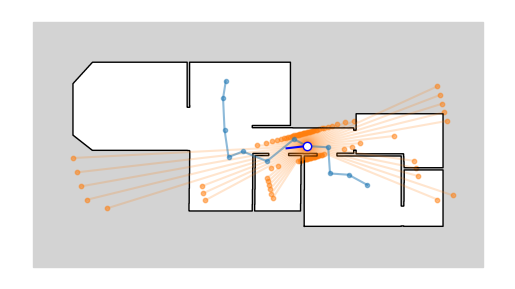

 0.308151 seconds (812.01 k allocations: 710.757 MiB, 37.17% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x7f916d19e950>

In [59]:
# Config
# ---

control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=100, a_noise=1e-5, z_noise=1e-1, max_z=30.)

p = poses[1]

# Initial trace
tr, = Gen.generate(loc_chain, (0, p, env, control_args, motion_args, sensor_args), choicemap());



hist = []

for t=1:T
    global tr;
    
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, senses[t+1].z, t)
    
    
    print("t: $(t)...")
    @time begin
        new_args = (t, p, env, control_args, motion_args, sensor_args)
        argdiffs = changes([1,0,0,0,0,0])
        tr, _,_,_  = update(tr, new_args, argdiffs, new_obs)


        for i=1:100
            tr, = mh(tr, select(t => :pose)) 
        end
    end
    
#     push!(hist, (tr, M))
        
end


draw_tr!(tr,5)

## Incremental Inference

In [48]:
function my_incremental_sampling(tr, args, diffs, selection, new_obs, num)
    
    tr,w = update(tr, args, diffs, new_obs)
    

    diffs = changes(zeros(length(args)))
    
    trs = []
    ws = []
    for i=1:num
        tr′, w′ = regenerate(tr, args, diffs, selection)
        push!(trs, tr′)
        push!(ws, w′)
    end
    return trs, ws
end;



t: 1...  0.300475 seconds (822.67 k allocations: 710.864 MiB, 39.48% gc time)
t: 2...  0.300324 seconds (822.11 k allocations: 710.854 MiB, 39.00% gc time)
t: 3...  0.305270 seconds (824.50 k allocations: 710.899 MiB, 37.79% gc time)
t: 4...  0.327410 seconds (824.80 k allocations: 710.904 MiB, 41.67% gc time)
t: 5...  0.347359 seconds (837.86 k allocations: 711.162 MiB, 41.79% gc time)
t: 6...  0.305617 seconds (829.35 k allocations: 711.006 MiB, 39.01% gc time)
t: 7...  0.320865 seconds (827.98 k allocations: 710.981 MiB, 41.76% gc time)
t: 8...  0.320530 seconds (833.28 k allocations: 711.072 MiB, 40.77% gc time)
t: 9...  0.330054 seconds (819.47 k allocations: 710.804 MiB, 42.57% gc time)
t: 10...  0.365581 seconds (810.96 k allocations: 710.630 MiB, 35.02% gc time)
t: 11...  0.341006 seconds (812.52 k allocations: 710.665 MiB, 43.06% gc time)
t: 12...

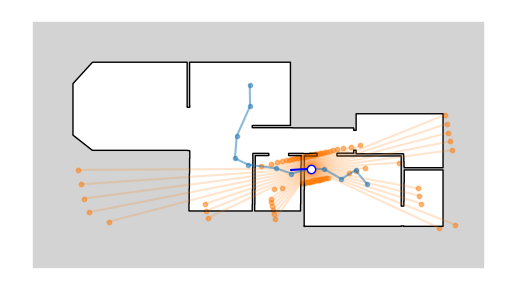

  0.340504 seconds (815.22 k allocations: 710.720 MiB, 41.46% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x7f9168d19f10>

In [58]:
# Config
# ---

control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=100, a_noise=1e-5, z_noise=1e-1, max_z=30.)

p = poses[1]

# Initial trace
tr, = Gen.generate(loc_chain, (0, p, env, control_args, motion_args, sensor_args), choicemap());



hist = []

for t=1:T
    global tr;
    
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, senses[t+1].z, t)
    
    

    new_args = (t, p, env, control_args, motion_args, sensor_args)
    argdiffs = changes([1,0,0,0,0,0])

    print("t: $(t)...")
    @time begin
    trs, ws = my_incremental_sampling(tr, new_args, argdiffs, select(t => :pose), new_obs, 100)
    end
    tr = trs[argmax(ws)]
        
end


draw_tr!(tr,5)

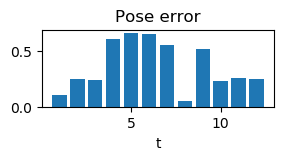

In [56]:
err = [norm(poses[t+1].x - tr[t => :pose => :x]) for t=1:T]
plt.figure(figsize=(3,1));
plt.title("Pose error"); plt.xlabel("t")
plt.bar(1:T, err);

# Loosen Sensor

In [50]:
sensor_mixture = HeterogeneousMixture([normal; uniform])

struct MultivariateSensor <: Gen.Distribution{Vector{Float64}} end
const mvsensor = MultivariateSensor()

function Gen.logpdf(::MultivariateSensor, z::AbstractArray{Float64,1}, 
                    mu::AbstractArray{Float64,1}, sig::Float64, max_val::Float64, w::Float64)
    
    n = length(mu)
    f = map((i) -> Gen.logpdf(sensor_mixture, z[i], [1.0-w, w], mu[i], sig, 0.0, max_val), 1:n)
    f = sum(f)
    return f
end

function Gen.random(::MultivariateSensor, 
                    mu::AbstractArray{Float64,1}, 
                    sig::Float64, 
                    max_val::Float64, 
                    w::Float64)
    n = length(mu)
    z = [sensor_mixture([1.0-w, w], mu[i], sig, 0.0, max_val) for i=1:n]
    return z
end

(::MultivariateSensor)(mu::AbstractArray{Float64,1}, 
                       sig::Float64, 
                       max_val::Float64, 
                       w::Float64) = Gen.random(MultivariateSensor(), mu, sig, max_val, w)

Gen.has_output_grad(::MultivariateSensor) = false;
Gen.has_argument_grads(::MultivariateSensor) = (false,false,false,false);

In [51]:
@gen function sensor_model_loosened(pose::Pose, env::Env, fov, n, z_noise, max_z, drop_out)
    x, hd = pose
    
    a0 = angles(fov, n)
    a = a0 .+ hd 
    z0 = cast(lightcone(a), x, env.segs; max_val=max_z)
    z  = @trace(mvsensor(z0, z_noise, max_z, drop_out), :z)
    
    return Measurement(z, a0)
end;

In [52]:
@gen (static) function new_localization_kernel(t::Int, 
                          pose::Pose, 
                          env::Env, 
                          control_args,
                          transition_args,
                          sensor_args, drop_out)

    mean_speed, max_speed, dhd_noise = control_args
    hd_noise, x_noise                = transition_args
    fov, n, z_noise, max_z  = sensor_args
    
    u     = @trace(control_prior(mean_speed, max_speed, dhd_noise), :u)
    pose  = @trace(motion_model(pose, u, hd_noise, x_noise), :pose)
    s     = @trace(sensor_model_loosened(pose, env, fov, n, z_noise, max_z, drop_out), :sense)
    
    return pose
end

new_loc_chain = Gen.Unfold(new_localization_kernel);
Gen.load_generated_functions();

# New Inference

t: 1...  1.505739 seconds (4.20 M allocations: 830.040 MiB, 12.36% gc time)
t: 2...  0.353294 seconds (1.18 M allocations: 675.037 MiB, 42.52% gc time)
t: 3...  0.340453 seconds (1.18 M allocations: 675.038 MiB, 40.66% gc time)
t: 4...  0.332488 seconds (1.19 M allocations: 675.061 MiB, 39.63% gc time)
t: 5...  0.321111 seconds (1.18 M allocations: 675.012 MiB, 40.99% gc time)
t: 6...  0.350092 seconds (1.18 M allocations: 675.037 MiB, 39.81% gc time)
t: 7...  0.328722 seconds (1.18 M allocations: 674.948 MiB, 39.19% gc time)
t: 8...  0.328322 seconds (1.17 M allocations: 674.765 MiB, 44.21% gc time)
t: 9...  0.340618 seconds (1.17 M allocations: 674.731 MiB, 39.63% gc time)
t: 10...  0.320804 seconds (1.17 M allocations: 674.802 MiB, 32.91% gc time)
t: 11...  0.321765 seconds (1.17 M allocations: 674.843 MiB, 35.97% gc time)
t: 12... 

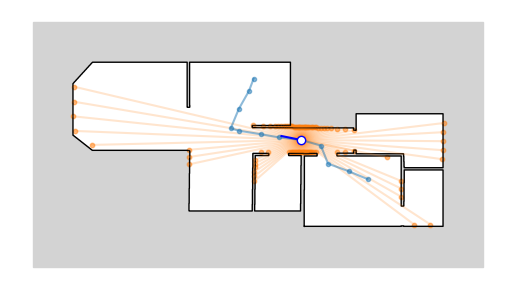

 0.329306 seconds (1.17 M allocations: 674.823 MiB, 38.56% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x7f916a55e4d0>

In [53]:
# Config
# ---

control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=100, z_noise=1e-1, max_z=30.)
drop_out = 0.2
p = poses[1]

# Initial trace
tr, = Gen.generate(new_loc_chain, (0, p, env, control_args, motion_args, sensor_args, drop_out), choicemap());


for t=1:T
    global tr;
    
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, senses[t+1].z, t)
    
    

    new_args = (t, p, env, control_args, motion_args, sensor_args, drop_out)
    argdiffs = changes([1,0,0,0,0,0])

    print("t: $(t)...")
    @time begin
    trs, ws = my_incremental_sampling(tr, new_args, argdiffs, select(t => :pose), new_obs, 100)
    end
    tr = trs[argmax(ws)]
        
end


draw_tr!(tr, 5)

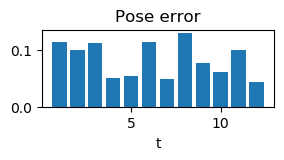

In [54]:
err = [norm(poses[t+1].x - tr[t => :pose => :x]) for t=1:T]
plt.figure(figsize=(3,1));
plt.title("Pose error"); plt.xlabel("t")
plt.bar(1:T, err);